In [14]:
import requests
import json
import pandas as pd
import numpy as np
import datetime
import matplotlib
from collections import Counter

In [2]:
## Prize Amounts
# Manager of the Month - €6
# Captain of the Month - €3
# Bonuses of the Month - €3
# Overall Winner - €80

In [3]:
# General related functions
def get_general_info():
    url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
    r = requests.get(url)
    general_json = r.json()
    return general_json

def get_active_gameweeks():
    general_json = get_general_info()
    general_json['events']
    active_gws = [(x['id'],datetime.datetime.strptime(x['deadline_time'], '%Y-%m-%dT%H:%M:%SZ').strftime('%B')) for x in general_json['events'] if datetime.datetime.strptime(x['deadline_time'], '%Y-%m-%dT%H:%M:%SZ')<datetime.datetime.now()]
    return active_gws
    

In [4]:
# League Related Functions
def get_league_data(league_id=1033889):
    url = 'https://fantasy.premierleague.com/api/leagues-classic/{league_id}/standings/'.format(league_id=league_id)
    r = requests.get(url)
    league_json = r.json()
    return league_json

def get_league_players(league_id=1033889):
    league_json = get_league_data()
    players = [(x['entry'],x['entry_name']) for x in league_json['standings']['results']]
    return players


In [5]:
# League Player related functions
def get_fpl_player_gw_data(player_id, gw):
    url = 'https://fantasy.premierleague.com/api/entry/{player_id}/event/{gw}/picks/'.format(player_id=player_id, gw=gw)
    r = requests.get(url)
    player_json = r.json()
    return player_json

def get_gw_fpl_players_df(player_id, gw):
    player_json = get_fpl_player_gw_data(player_id, gw)
    player_df = pd.DataFrame(player_json['picks'])
    transfer_cost = player_json['entry_history']['event_transfers_cost']
    return player_df, transfer_cost
    
    

In [6]:
# Actual Football player related functions
def get_player_gw_data(gw):
    url = 'https://fantasy.premierleague.com/api/event/{gw}/live/'.format(gw=gw)
    r = requests.get(url)
    player_json = r.json()
    return player_json

def get_gw_players_df(gw):
    player_json = get_player_gw_data(gw)
    id_list = [x['id'] for x in player_json['elements']]
    bonus_list = [x['stats']['bonus'] for x in player_json['elements']]
    points_list = [x['stats']['total_points'] for x in player_json['elements']]

    player_df = pd.DataFrame({
        'element':id_list,
        'bonus':bonus_list,
        'points':points_list
    })
    
    return player_df


In [7]:
## For each gameweek
## For each player in that gameweek, get their points

active_gws = get_active_gameweeks()
players = get_league_players()

gw_list = []
player_list = []
total_points_list = []
total_bonus_list = []
captain_list = []
transfer_list = []
month_list = []
bench_list = []


for x in active_gws:
    player_df = get_gw_players_df(x[0])
    for y in players:
        fpl_player_df, transfer_cost = get_gw_fpl_players_df(y[0], x[0])
        fpl_player_df2 = fpl_player_df.merge(player_df, how='left')
        fpl_player_df2['live_points'] = fpl_player_df2['points']*fpl_player_df2['multiplier']
        fpl_player_df2['live_bonus'] = fpl_player_df2['bonus']*(fpl_player_df2['multiplier']/fpl_player_df2['multiplier'])
        fpl_player_df2['captain_points'] = fpl_player_df2['live_points']*fpl_player_df2['is_captain']
        fpl_player_df2['bench_points'] = [x if y==0 else 0 for x,y in zip(fpl_player_df2['points'], fpl_player_df2['multiplier'])]
        
        gw_list.append(x[0])
        month_list.append(x[1])
        player_list.append(y[1])
        total_points_list.append(fpl_player_df2['live_points'].sum())
        total_bonus_list.append(fpl_player_df2['live_bonus'].sum())
        captain_list.append(fpl_player_df2['captain_points'].sum())
        bench_list.append(fpl_player_df2['bench_points'].sum())
        transfer_list.append(transfer_cost)
        
        
output_df = pd.DataFrame({
    'gw': gw_list,
    'month': month_list,
    'team_name': player_list,
    'gross_points': total_points_list,
    'bonus_points': total_bonus_list,
    'captain_points': captain_list,
    'transfer_cost': transfer_list,
    'bench_points': bench_list
})

output_df['net_points'] = output_df['gross_points'] - output_df['transfer_cost']


In [8]:
output_df

,gw,month,team_name,gross_points,bonus_points,captain_points,transfer_cost,bench_points,net_points
0,1,August,abcdefc,98,11.0,40,0,4,98
1,1,August,Deftoneys,85,9.0,34,0,2,85
2,1,August,Premier Club,75,5.0,34,0,8,75
3,1,August,Teamo Werner,69,6.0,34,0,2,69
4,2,August,abcdefc,76,12.0,16,0,7,76
...,...,...,...,...,...,...,...,...,...
147,37,May,Teamo Werner,62,10.0,4,0,10,62
148,38,May,abcdefc,70,6.0,20,8,1,62
149,38,May,Deftoneys,80,10.0,24,8,3,72
150,38,May,Premier Club,69,2.0,24,4,2,65


In [9]:
overall_leaderboard = output_df[['team_name','bonus_points','captain_points','net_points','bench_points','transfer_cost']].groupby('team_name', as_index=False).sum()
overall_leaderboard.sort_values('net_points', ascending=False)

,team_name,bonus_points,captain_points,net_points,bench_points,transfer_cost
3,abcdefc,223.0,691,2359,198,72
0,Deftoneys,221.0,702,2351,247,76
1,Premier Club,212.0,609,2326,189,36
2,Teamo Werner,197.0,620,2283,202,32


In [10]:
monthly_leaderboard = output_df[['month','team_name','bonus_points','captain_points','net_points','bench_points']].groupby(['month','team_name'], as_index=False).sum()
monthly_leaderboard.sort_values(['month','net_points'], ascending=False)

,month,team_name,bonus_points,captain_points,net_points,bench_points
37,September,Premier Club,18.0,54,189,27
38,September,Teamo Werner,19.0,44,188,30
36,September,Deftoneys,9.0,56,166,18
39,September,abcdefc,7.0,44,157,7
34,October,Teamo Werner,19.0,88,240,23
35,October,abcdefc,25.0,46,233,3
33,October,Premier Club,18.0,88,228,29
32,October,Deftoneys,13.0,88,213,19
29,November,Premier Club,26.0,74,272,23
31,November,abcdefc,25.0,38,218,10


In [11]:
monthly_leaderboard[(monthly_leaderboard['month']=='May')].sort_values(['month','net_points'], ascending=False)

,month,team_name,bonus_points,captain_points,net_points,bench_points
26,May,Teamo Werner,34.0,84,291,25
24,May,Deftoneys,36.0,90,283,20
27,May,abcdefc,19.0,103,216,1
25,May,Premier Club,7.0,39,167,9


In [12]:
monthly_wins = []
monthly_captain = []
monthly_bonus = []
for i,x in monthly_leaderboard.groupby('month'):
    x = x.reset_index()
    monthly_wins.append(x.loc[np.argmax(x['net_points'])]['team_name'])
    monthly_captain.append(x.loc[np.argmax(x['captain_points'])]['team_name'])
    monthly_bonus.append(x.loc[np.argmax(x['bonus_points'])]['team_name'])
    
monthly_winners = pd.DataFrame({
    'monthly_win': monthly_wins,
    'monthly_captain': monthly_captain,
    'monthly_bonus': monthly_bonus,
})

In [15]:
#Worst Captain
data = output_df.loc[np.argmin(output_df['captain_points'])]
print('The lowest captain points was in Gameweek {gw}, where {name} had {score} points'.format(name=data['team_name'], gw=data['gw'], score=data['captain_points']))

#Best Captain
data = output_df.loc[np.argmax(output_df['captain_points'])]
print('The highest captain points was in Gameweek {gw}, where {name} had {score} points'.format(name=data['team_name'], gw=data['gw'], score=data['captain_points']))

print('\n')
#Best Gameweek
data = output_df.loc[np.argmax(output_df['gross_points'])]
print('The highest gameweek points was in Gameweek {gw}, where {name} had {score} points'.format(name=data['team_name'], gw=data['gw'], score=data['gross_points']))

#Worst Gameweek
data = output_df.loc[np.argmin(output_df['gross_points'])]
print('The lowest gameweek points was in Gameweek {gw}, where {name} had {score} points'.format(name=data['team_name'], gw=data['gw'], score=data['gross_points']))

print('\n')
#Most Transfer Spend
data = overall_leaderboard.loc[np.argmax(overall_leaderboard['transfer_cost'])]
print('{name} spent the most on transfers with {score} points spent'.format(name=data['team_name'], score=data['transfer_cost']))

print('\n')
#Team of the Month breakdown
tom_data = Counter(monthly_winners['monthly_win']).most_common()
for i in tom_data:
    print('{name} won {score} team of the month awards'.format(name=i[0], score=i[1]))

print('\n')
#Captain of the Month breakdown
cap_data = Counter(monthly_winners['monthly_captain']).most_common()
for i in cap_data:
    print('{name} won {score} captain of the month awards'.format(name=i[0], score=i[1]))

print('\n')
#Bonus of the Month breakdown
bon_data = Counter(monthly_winners['monthly_bonus']).most_common()
for i in bon_data:
    print('{name} won {score} bonus of the month awards'.format(name=i[0], score=i[1]))

print('\n')
#Overall awards
award_data = cap_data+bon_data+tom_data
amount_data = (cap_data*3)+(bon_data*3)+(tom_data*6)
for i in players:
    awards = sum([x[1] for x in award_data if i[1] == x[0]])
    amount = sum([x[1] for x in amount_data if i[1] == x[0]])
    print('{name} won {score} awards with a total value of €{amount}'.format(name = i[1], score = awards, amount = amount))
    

The lowest captain points was in Gameweek 11, where abcdefc had -2 points
The highest captain points was in Gameweek 26, where Deftoneys had 84 points


The highest gameweek points was in Gameweek 26, where abcdefc had 149 points
The lowest gameweek points was in Gameweek 23, where abcdefc had 27 points


Deftoneys spent the most on transfers with 76 points spent


Premier Club won 6 team of the month awards
abcdefc won 2 team of the month awards
Teamo Werner won 2 team of the month awards


abcdefc won 4 captain of the month awards
Deftoneys won 4 captain of the month awards
Premier Club won 2 captain of the month awards


Premier Club won 3 bonus of the month awards
abcdefc won 3 bonus of the month awards
Deftoneys won 2 bonus of the month awards
Teamo Werner won 2 bonus of the month awards


abcdefc won 9 awards with a total value of €33
Deftoneys won 6 awards with a total value of €18
Premier Club won 11 awards with a total value of €51
Teamo Werner won 4 awards with a total value 

In [16]:
cum_points_df = output_df[['gw','team_name','net_points']].groupby(['gw','team_name']).sum().groupby('team_name').cumsum().reset_index()


<AxesSubplot:xlabel='gw'>

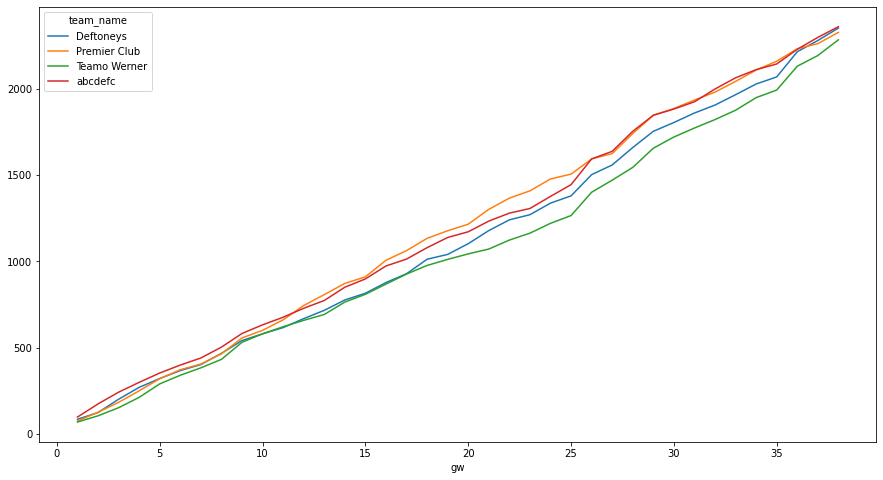

In [21]:
cum_points_df.pivot(index='gw', columns='team_name', values='net_points').plot(figsize=(15,8))